In [1]:
import numpy as np
import cvxpy
import matplotlib.pyplot as plt
#from DrawingUtils import plot_extreme_points,graph_plane,PlotPolytope
import random as rnd
import time
from IPython.display import clear_output

%matplotlib notebook
%matplotlib inline
%config InlineBackend.close_figures=False

# Core functions

## Constructing linear constraints using McCormick envelopes

In [2]:
def McCormick(w,x,y,x_bounds,y_bounds):
    xL,xU = x_bounds
    yL,yU = y_bounds

    c = []
#     c.append(w >= xL*y + x*yL - xL*yL)
    c.append(w >= xU*y + x*yU - xU*yU)
    c.append(w <= xU*y + x*yL - xU*yL)
#     c.append(w <= x*yU + xL*y - xL*yU)
    return c

## Solving linear program

In [3]:
def bounds(x,constraints,Npast=0):

    objective_max = cvxpy.Maximize(x)
    problem_maximum = cvxpy.Problem(objective_max,constraints[-Npast:])
    value_max = problem_maximum.solve(solver=cvxpy.GUROBI)

    objective_min = cvxpy.Minimize(x)
    problem_minimum = cvxpy.Problem(objective_min,constraints[-Npast:])
    value_min = problem_minimum.solve(solver=cvxpy.GUROBI)

    return (value_min,value_max)

# Lotka Volterra
(Implementation by Anand, based of "Van Der Pol" implementation by Vicenc)

Lotka Volterra (discretized) dynamics:

$x_{t+1} = (a - by_t - \lambda x_t)x_t \Delta_t + x_t $         
$y_{t+1} = (cx_t - d - \mu y_t)y_t \Delta_t + y_t $

$a,b,c,d,\lambda,\mu > 0 $

In [4]:
def forwardEulerLV(x0,y0,constants,plot=True):
    
    T = constants["T"]
    a, b, lamb, c, d, mu, del_t = constants["a"], constants["b"], constants["lambda"], constants["c"], constants["d"], constants["mu"], constants["del_t"]
    
    xs, ys = [x0], [y0]
    x,y = x0, y0
    for t in range(T):
        x, y = (a-b*y-lamb*x)*x*del_t + x, (c*x-d-mu*y)*y*del_t + y
        xs.append(x)
        ys.append(y)
        
    if plot:
        plt.figure()
        plt.plot(xs, ys, '*')
    return xs, ys

In [5]:
def lotkaVolterraConstraints(T=1,variables=[],constants={},constraints=[],control_bounds=[],Npast=0):
    times = []
    T = constants["T"]
    for t in range(T):
        tt = time.time()
        
        x = variables[t]["x"]
        x_bounds = bounds(x,constraints,Npast=Npast)
        y = variables[t]["y"]
        y_bounds = bounds(y,constraints,Npast=Npast)

        ######### lil plot
        xL,xU = x_bounds
        yL,yU = y_bounds
        print([(xL,xU),(yL,yU)])
#         clear_output(wait=True)
        fig = plt.figure(1)
        if t>0: 
            #plt.clf()
            plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')
            plt.plot([xL,xL,xU,xU,xL],[yL,yU,yU,yL,yL],'k')
            # print("x_b: ",x_bounds)
            # print("y_b: ",y_bounds)
        fig.canvas.draw()   # draw
        plt.pause(1.01)
        ########
        
        a, b, lamb, c, d, mu, del_t = constants["a"], constants["b"], constants["lambda"], constants["c"], constants["d"], constants["mu"], constants["del_t"]
        
        k_1 = variables[t]["k_1"]
        constraints.append(k_1 == (a - b*y - lamb*x)*del_t)
        k_1_bounds = bounds(k_1,constraints,Npast=Npast)
        
        l_1 = variables[t]["l_1"]
        constraints.extend(McCormick(l_1,k_1,x,k_1_bounds,x_bounds))
        
        k_2 = variables[t]["k_2"]
        constraints.append(k_2 == (c*x - d - mu*y)*del_t)
        k_2_bounds = bounds(k_2,constraints,Npast=Npast)
        
        l_2 = variables[t]["l_2"]
        constraints.extend(McCormick(l_2,k_2,y,k_2_bounds,y_bounds))
        
        x_new = variables[t+1]["x"]
        constraints.append(x_new == l_1 + x)
        
        y_new = variables[t+1]["y"]
        constraints.append(y_new == l_2 + y)

        tt = time.time() - tt
        times.append(tt)
        print("Time for ",t,"-th loop: ",tt)

    # plt.figure(2)
    # plt.plot(times,'r*')
    
    xs,ys = forwardEulerLV(constants["x0"],constants["y0"],constants,plot=False)
    for i in range(len(xs)):
        print(xs[i],ys[i])
    plt.plot(xs, ys, '*')
    plt.show()
    
    return variables,constraints

## Initial Setup

In [8]:
# horizon and forward Euler time step
T = 3
del_t = -0.1

# box constraints for initial state
x0 = 1
y0 = 1
x_dev = 0.01
y_dev = 0.01

x_up_b = x_dev + x0
x_lw_b = -1*x_dev + x0
y_up_b = y_dev + y0
y_lw_b = -1*y_dev + y0

# constants for dynamics
constants = {"a":1, "b":1, "lambda":1, 
             "c":1, "d":1, "mu":1, 
             "T":T, "del_t":del_t,
             "x0":x0, "y0":y0}

## Generate plots

[(0.99, 1.01), (0.99, 1.01)]


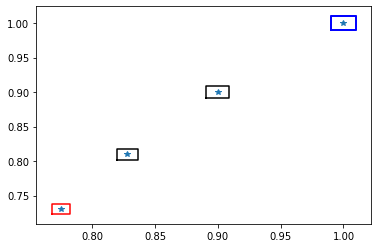

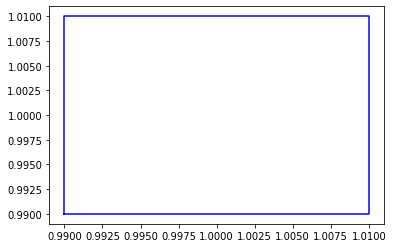

Time for  0 -th loop:  1.5295491218566895
[(1.08694, 1.1130200000000001), (1.08694, 1.1130200000000001)]


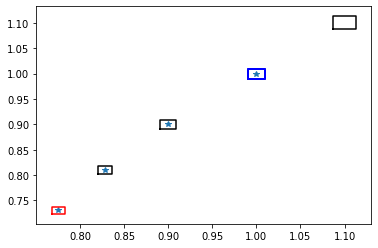

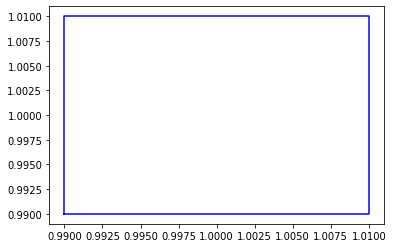

Time for  1 -th loop:  1.6580638885498047
[(1.21462767332, 1.2492603261200002), (1.19288887332, 1.2269999261200002)]


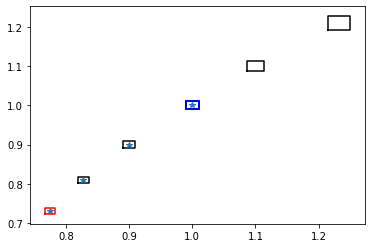

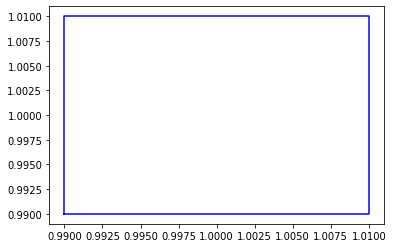

Time for  2 -th loop:  1.6010432243347168
1 1
1.1 1.1
1.2320000000000002 1.2100000000000002
1.4096544000000004 1.3283380000000002


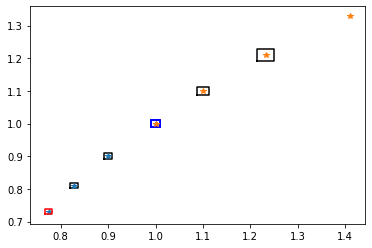

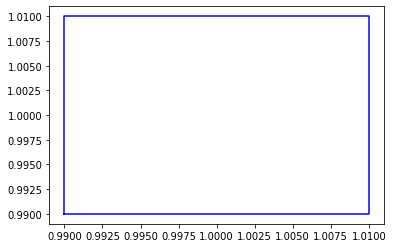

In [9]:
variables = [{"x":cvxpy.Variable(),"y":cvxpy.Variable(),"k_1":cvxpy.Variable(),"k_2":cvxpy.Variable(),"l_1":cvxpy.Variable(),"l_2":cvxpy.Variable()} for t in range(T+1)]

plt.figure()
plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')

x = variables[0]["x"]
y = variables[0]["y"]

constraints = []
constraints.append(x >= x_lw_b)
constraints.append(x <= x_up_b)
constraints.append(y >= y_lw_b)
constraints.append(y <= y_up_b)

control_bounds = [(0.2,1.0) for t in range(T)]
#control_bounds = [(2.0,2.5),(2.0,2.5),(2.0,2.5),(2.0,2.5)]

variables,constraints = lotkaVolterraConstraints(T,variables,constants,constraints,control_bounds)
xL,xU = bounds(variables[-1]["x"],constraints)
yL,yU = bounds(variables[-1]["y"],constraints)

plt.plot([xL,xL,xU,xU,xL],[yL,yU,yU,yL,yL],'r')
# plt.pause(1000)